In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
NOAK = False

In [13]:
if NOAK:
  csv_path = './results/results_steel_deployment_noak_1000.csv'
  clean_save_path = './results/results_steel_deployment_noak_1000_clean.csv'
  save_fig_path = './results/breakeven_price_steel_noak_1000.png'
else:
  csv_path = './results/results_steel_deployment_foak.csv'
  clean_save_path = './results/results_steel_deployment_foak_clean.csv'
  save_fig_path = './results/breakeven_price_steel_foak.png'
df = pd.read_csv(csv_path)
df.sort_values(by=['Breakeven coal price ($/ton)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df

,Plant,H2 Dem (kg/day),Aux Elec Dem (MWe),Alkaline,HTSE,PEM,ANR type,# ANR modules,Breakeven coal price ($/ton),Ann. CO2 emissions (kgCO2eq/year),Steel prod. (ton/year),Steel sales ($/year),Net Rev. ($/year)
0,Cleveland-Cliffs Indiana Harbor steel plant,1.033714e+06,341.347061,0,1034.0,0,iMSR,9,388.943294,3.064169e+08,5236000.0,4.188800e+09,3.470452e+08
1,Cleveland-Cliffs Cleveland steel plant,5.547627e+05,183.190459,0,555.0,0,iMSR,5,394.772791,1.644524e+08,2810000.0,2.248000e+09,1.753879e+08
2,U.S. Steel Gary Works,1.307345e+06,431.703636,0,1308.0,0,iMSR,12,397.931748,3.875548e+08,6622000.0,5.297600e+09,3.994473e+08
3,Cleveland-Cliffs Riverdale steel plant,1.974245e+05,65.192334,0,198.0,0,PBR-HTGR,3,405.472696,5.789983e+07,1000000.0,8.000000e+08,5.532160e+07
4,Cleveland-Cliffs Burns Harbor steel plant,7.176379e+05,236.974134,0,718.0,0,PBR-HTGR,11,406.993623,2.103095e+08,3635000.0,2.908000e+09,1.974286e+08
5,Cleveland-Cliffs Middletown steel plant,4.126171e+05,136.251978,0,413.0,0,iMSR,4,407.741493,1.223345e+08,2090000.0,1.672000e+09,1.124783e+08
6,U.S. Steel Edgar Thomson Plant,4.102480e+05,135.469670,0,411.0,0,iMSR,4,408.834658,1.216669e+08,2078000.0,1.662400e+09,1.103265e+08
7,U.S. Steel Granite City Works,5.014581e+05,165.588528,0,502.0,0,iMSR,5,413.006597,1.486816e+08,2540000.0,2.032000e+09,1.278296e+08
8,Cleveland-Cliffs Dearborn steel plant,4.935612e+05,162.980835,0,494.0,0,iMSR,5,416.033267,1.463313e+08,2500000.0,2.000000e+09,1.207999e+08


In [14]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')
anr_param

,Reactor,Type,Power in MWe,Power in MWt,MSL in MWe,Thermal Efficiency,Thermal transfer efficiency,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),CAPEX $/MWe,FOPEX $/MWe-y,Max Modules,VOM in $/MWh-e,Startupfixedcost in $,Life (y)
0,iPWR,PWR,77.0,250,15.4,0.31,1.000,20,0.4,24.0,302,5535000,115000,12,0.75,38500,30
1,HTGR,HTGR,164.0,350,32.8,0.47,0.897,20,6.0,984.0,950,7500000,164000,4,0.00,82000,30
2,PBR-HTGR,HTGR,80.0,200,32.0,0.40,0.751,20,2.4,48.0,750,4569000,100000,12,0.00,40000,30
3,iMSR,MSR,141.0,300,28.2,0.47,0.936,20,0.6,84.6,700,4091000,85000,12,0.50,70500,30
4,Micro,HTGR,6.7,20,2.7,0.33,0.897,20,6.0,24.0,630,10902000,264000,12,0.00,3350,30


### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [15]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven coal price ($/ton)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df

,Plant,H2 Dem (kg/day),Aux Elec Dem (MWe),Alkaline,HTSE,PEM,ANR type,# ANR modules,Breakeven coal price ($/ton),Ann. CO2 emissions (kgCO2eq/year),Steel prod. (ton/year),Steel sales ($/year),Net Rev. ($/year),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt)
0,Cleveland-Cliffs Indiana Harbor steel plant,1.033714e+06,341.347061,0,1034.0,0,iMSR,9,388.943294,3.064169e+08,5236000.0,4.188800e+09,3.470452e+08,300,iMSR,2700,2.7
1,Cleveland-Cliffs Cleveland steel plant,5.547627e+05,183.190459,0,555.0,0,iMSR,5,394.772791,1.644524e+08,2810000.0,2.248000e+09,1.753879e+08,300,iMSR,1500,4.2
2,U.S. Steel Gary Works,1.307345e+06,431.703636,0,1308.0,0,iMSR,12,397.931748,3.875548e+08,6622000.0,5.297600e+09,3.994473e+08,300,iMSR,3600,7.8
7,Cleveland-Cliffs Riverdale steel plant,1.974245e+05,65.192334,0,198.0,0,PBR-HTGR,3,405.472696,5.789983e+07,1000000.0,8.000000e+08,5.532160e+07,200,PBR-HTGR,600,8.4
8,Cleveland-Cliffs Burns Harbor steel plant,7.176379e+05,236.974134,0,718.0,0,PBR-HTGR,11,406.993623,2.103095e+08,3635000.0,2.908000e+09,1.974286e+08,200,PBR-HTGR,2200,10.6
3,Cleveland-Cliffs Middletown steel plant,4.126171e+05,136.251978,0,413.0,0,iMSR,4,407.741493,1.223345e+08,2090000.0,1.672000e+09,1.124783e+08,300,iMSR,1200,11.8
4,U.S. Steel Edgar Thomson Plant,4.102480e+05,135.469670,0,411.0,0,iMSR,4,408.834658,1.216669e+08,2078000.0,1.662400e+09,1.103265e+08,300,iMSR,1200,13.0
5,U.S. Steel Granite City Works,5.014581e+05,165.588528,0,502.0,0,iMSR,5,413.006597,1.486816e+08,2540000.0,2.032000e+09,1.278296e+08,300,iMSR,1500,14.5
6,Cleveland-Cliffs Dearborn steel plant,4.935612e+05,162.980835,0,494.0,0,iMSR,5,416.033267,1.463313e+08,2500000.0,2.000000e+09,1.207999e+08,300,iMSR,1500,16.0


### Compute cumulative number of viable steel plants and ANR modules

In [16]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR steel plants count'] = df.index+1
df.head(5)

,Plant,H2 Dem (kg/day),Aux Elec Dem (MWe),Alkaline,HTSE,PEM,ANR type,# ANR modules,Breakeven coal price ($/ton),Ann. CO2 emissions (kgCO2eq/year),Steel prod. (ton/year),Steel sales ($/year),Net Rev. ($/year),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR steel plants count
0,Cleveland-Cliffs Indiana Harbor steel plant,1.033714e+06,341.347061,0,1034.0,0,iMSR,9,388.943294,3.064169e+08,5236000.0,4.188800e+09,3.470452e+08,300,iMSR,2700,2.7,9,1
1,Cleveland-Cliffs Cleveland steel plant,5.547627e+05,183.190459,0,555.0,0,iMSR,5,394.772791,1.644524e+08,2810000.0,2.248000e+09,1.753879e+08,300,iMSR,1500,4.2,14,2
2,U.S. Steel Gary Works,1.307345e+06,431.703636,0,1308.0,0,iMSR,12,397.931748,3.875548e+08,6622000.0,5.297600e+09,3.994473e+08,300,iMSR,3600,7.8,26,3
3,Cleveland-Cliffs Riverdale steel plant,1.974245e+05,65.192334,0,198.0,0,PBR-HTGR,3,405.472696,5.789983e+07,1000000.0,8.000000e+08,5.532160e+07,200,PBR-HTGR,600,8.4,29,4
4,Cleveland-Cliffs Burns Harbor steel plant,7.176379e+05,236.974134,0,718.0,0,PBR-HTGR,11,406.993623,2.103095e+08,3635000.0,2.908000e+09,1.974286e+08,200,PBR-HTGR,2200,10.6,40,5


### Compute avoided carbon emissions 

In [17]:
demand_steel_df = pd.read_excel('./h2_demand_bfbof_steel_us_2022.xlsx', sheet_name='processed')
df = df.merge(demand_steel_df, on='Plant')

In [18]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['GHG QUANTITY (METRIC TONS CO2e)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df

,Plant,H2 Dem (kg/day),Aux Elec Dem (MWe),Alkaline,HTSE,PEM,ANR type,# ANR modules,Breakeven coal price ($/ton),Ann. CO2 emissions (kgCO2eq/year),...,COUNTY NAME,ZIP CODE,Status,Main production process,GHG QUANTITY (METRIC TONS CO2e),Steel production capacity (ttpa),Hydrogen demand (kg/day),Electricity demand (MWe),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,Cleveland-Cliffs Indiana Harbor steel plant,1.033714e+06,341.347061,0,1034.0,0,iMSR,9,388.943294,3.064169e+08,...,Lake,46312,operating,integrated (BF),5434569,5236,1.033714e+06,341.347061,5.128152,5.128152
1,Cleveland-Cliffs Cleveland steel plant,5.547627e+05,183.190459,0,555.0,0,iMSR,5,394.772791,1.644524e+08,...,Cuyahoga,44105,operating,integrated (BF),2942469,2810,5.547627e+05,183.190459,2.778017,7.906169
2,U.S. Steel Gary Works,1.307345e+06,431.703636,0,1308.0,0,iMSR,12,397.931748,3.875548e+08,...,Lake,46402,operating,integrated (BF),10300727,6622,1.307345e+06,431.703636,9.913172,17.819341
3,Cleveland-Cliffs Riverdale steel plant,1.974245e+05,65.192334,0,198.0,0,PBR-HTGR,3,405.472696,5.789983e+07,...,COOK COUNTY,60827,operating,oxygen,134985,1000,1.974245e+05,65.192334,0.077085,17.896426
4,Cleveland-Cliffs Burns Harbor steel plant,7.176379e+05,236.974134,0,718.0,0,PBR-HTGR,11,406.993623,2.103095e+08,...,PORTER COUNTY,46304,operating,integrated (BF),6839238,3635,7.176379e+05,236.974134,6.628929,24.525355
5,Cleveland-Cliffs Middletown steel plant,4.126171e+05,136.251978,0,413.0,0,iMSR,4,407.741493,1.223345e+08,...,Butler,45043,operating,integrated (BF),3227354,2090,4.126171e+05,136.251978,3.105020,27.630374
6,U.S. Steel Edgar Thomson Plant,4.102480e+05,135.469670,0,411.0,0,iMSR,4,408.834658,1.216669e+08,...,Allegheny,15104,operating,integrated (BF),2995635,2078,4.102480e+05,135.469670,2.873968,30.504342
7,U.S. Steel Granite City Works,5.014581e+05,165.588528,0,502.0,0,iMSR,5,413.006597,1.486816e+08,...,MADISON COUNTY,62040,operating,integrated (BF),1932947,2540,5.014581e+05,165.588528,1.784265,32.288608
8,Cleveland-Cliffs Dearborn steel plant,4.935612e+05,162.980835,0,494.0,0,iMSR,5,416.033267,1.463313e+08,...,WAYNE COUNTY,48120,operating,integrated (BF),1015576,2500,4.935612e+05,162.980835,0.869245,33.157852


### Save clean version of results


In [19]:
df_clean = df[["Plant", 'Steel production capacity (ttpa)', 'H2 Dem (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Rev. ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven coal price ($/ton)']]
df_clean.sort_values(by=['Steel production capacity (ttpa)'], ascending=False, inplace=True)
df_clean['H2 Dem (kg/day)'] /=1e3
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem (kg/day)'] = df_clean['H2 Dem (kg/day)'].apply(lambda x:np.round(x,1))
df_clean['Net Rev. ($/year)'] = df_clean['Net Rev. ($/year)'].apply(lambda x: np.round(x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Rev. ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))
df_clean['Breakeven coal price ($/ton)'] = df_clean['Breakeven coal price ($/ton)'].apply(lambda x : np.round(x,1))
df_clean.rename(columns={'H2 Dem (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.to_csv(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_21584\3602139538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.sort_values(by=['Steel production capacity (ttpa)'], ascending=False, inplace=True)
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_21584\3602139538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_21584\3602139538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

### Plots

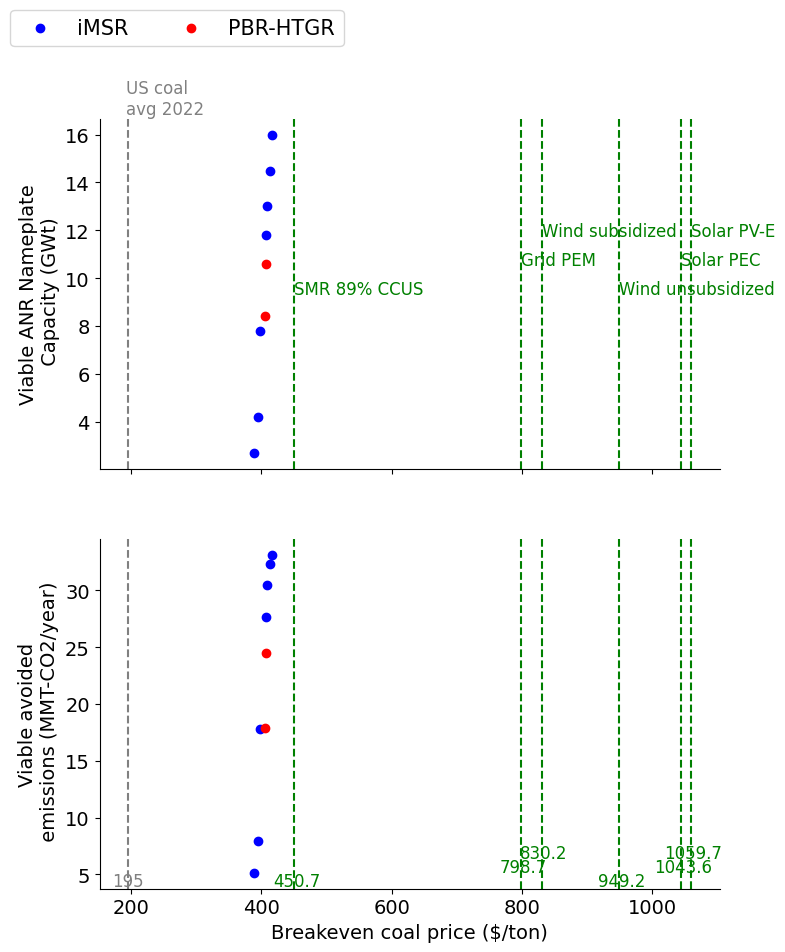

In [20]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n emissions (MMT-CO2/year)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven coal price ($/ton)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_steel.csv')
    res_be.sort_values(by='Breakeven price ($/tcoal)', inplace=True)
    res_be['Breakeven price ($/tcoal)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/tcoal)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/tcoal)'])
    coal_vertical_lines = [195]
    for line in coal_vertical_lines:
        axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


ng_labels = ['US coal\navg 2022']
for x, l in zip(coal_vertical_lines, ng_labels):
    axs[0].text(x-2, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[i].get_ylim()[0]+1.5, str(x), color='grey', fontsize=12, va='top', ha='center')

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+1.2*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x+3, axs[1].get_ylim()[0]+1.5+1.2*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven coal price ($/ton)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)